# **import packages**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#viz data
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#model
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
import sklearn.metrics

import warnings
warnings.filterwarnings("ignore")

# **load data**

Data source: https://github.com/ruzcmc/ClickbaitIndo-textclassifier/blob/master/all_agree.csv <br>


**Clickbait Classification Indonesian Online News Headline** <br>
The dataset consist of news headline that have been labeled clibckbait (1) or non-clickbait (0) <br>

In [2]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/ruzcmc/ClickbaitIndo-textclassifier/master/all_agree.csv')
raw_data.head()

,title,label,label_score
0,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",non-clickbait,0
1,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,non-clickbait,0
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1
3,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",non-clickbait,0
4,MPR: Amandemen UUD 1945 Tak Akan Melebar ke Ma...,non-clickbait,0


# **preprocessing part 1**

non-clickbait    5297
clickbait        3316
Name: label, dtype: int64


<AxesSubplot: ylabel='Type'>

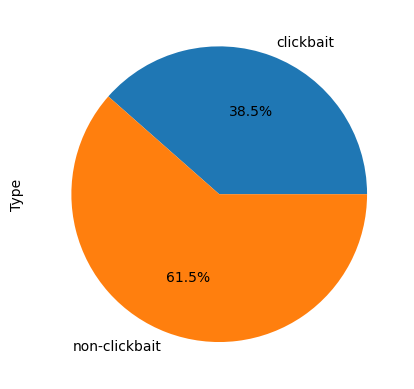

In [3]:
#comparing the number of clickbait and non-clickbait news headline
print(raw_data['label'].value_counts())

raw_data.groupby('label').size().plot(kind='pie',
                                       y = 'label',
                                       label = "Type",
                                       autopct='%1.1f%%')

from the pie chart we know that the data is unbalanced, with a ratio of 38.5% for clickbait and 61.5% for non-clickbait. so we have to balancing the data after cleaning it.

## text cleaning

In [4]:
# lowering text, and remove unnecessary stuff kinda punctuation, link, hashtag, and other
#from 'Hai my name is @Annabelle' into 'hai my name is annabelle'
def regex(text):
    text = text.lower() 
    text=text.strip()  
    text= re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text= re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'\s*(https|http|com)',' ',text)
    return text

#tokenize sentence, from 'hai my name is annabelle', into ['hai','my','name','is','annabelle']
def tokenize(x):
    return word_tokenize(x)

#remove unnecessary word in list, from ['hai','my','name','is','annabelle'], into ['name','annabelle']
more_stopword = ['dengan', 'ia','bahwa','oleh','sebut','bikin','gara']
list_stopwords = set(stopwords.words('Indonesian')+more_stopword)

def remove_stopwords(x):
    return [word for word in x if word not in list_stopwords]

#unlist the list, from ['name','annabelle'], into 'name annabelle'
def unlist(x):
    return ' '.join(x)


In [5]:
def preprocess(df,col_text,col_label):
    df = df[[col_label,col_text]]
    df.columns = ['y','text']
    df['text'] = df['text'].apply(regex)
    df['text'] = df['text'].apply(tokenize)
    df['text'] = df['text'].apply(remove_stopwords)
    df['text'] = df['text'].apply(unlist)
    return df

data_clean = preprocess(raw_data,'title','label_score')
data_clean.head()

,y,text
0,0,masuk radar pilwalkot medan menantu jokowi ber...
1,0,malaysia sudutkan ri isu kabut asap invasi babi
2,1,viral driver ojol bekasi pesanan makanan pakai...
3,0,kemensos salurkan rp m korban kerusuhan sosial...
4,0,mpr amandemen uud melebar


In [6]:
compare_data = pd.DataFrame({'raw':raw_data['title'],
                            'clean':data_clean['text']})
compare_data.head()

,raw,clean
0,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",masuk radar pilwalkot medan menantu jokowi ber...
1,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,malaysia sudutkan ri isu kabut asap invasi babi
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,viral driver ojol bekasi pesanan makanan pakai...
3,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",kemensos salurkan rp m korban kerusuhan sosial...
4,MPR: Amandemen UUD 1945 Tak Akan Melebar ke Ma...,mpr amandemen uud melebar


cleaning the data so the data has a same format (lowercase) and remove unnecessary elemen kinda punctuation, or non-relevant word.

## balancing data

In [7]:
cb_text = data_clean[data_clean.y==1]
ncb_text = data_clean[data_clean.y==0]

#downsampling
ncb_text = data_clean[data_clean.y==0].sample(n=len(cb_text),random_state=11)
data_balance = cb_text.append(ncb_text).reset_index(drop=True)
# balance_msg = spam_msg.append(ham_msg).reset_index(drop=True)
# balance_msg
data_balance

,y,text
0,1,viral driver ojol bekasi pesanan makanan pakai...
1,1,motor nyangkut bambu sleman
2,1,pesan gamblang poyuono menolak revisi uu kpk
3,1,kocak maling rumah mewah jakut terekam cctv bi...
4,1,viral video diduga baku tembak sleman polisi
...,...,...
6627,0,paripurna dpr tetapkan pansus pengkaji peminda...
6628,0,via vallen senang dangdut rajai musik indonesia
6629,0,rima melati besuk bj habibie rabu sore
6630,0,core bi rate turun dampaknya


In [8]:
data_balance['y'].value_counts()

1    3316
0    3316
Name: y, dtype: int64

balancing is used for make a has a same number each number. now we have a same number of clickbait and non-clickbait

## wordcloud and most frequently words

In [9]:
class word_word_word:
    def __init__(self,text_series,title=''):
        self.title = title
        self.text_series = text_series
        self.title=title
        
        self.token_text = self.text_series.apply(tokenize)
        self.token_word = []
        for i in self.token_text:
            for j in i:
                self.token_word.append(j)

        from nltk.probability import FreqDist
        self.fdist = FreqDist(self.token_word)
        self.fdist1 = dict(self.fdist.most_common(10))

    def word_cloud(self):
        import matplotlib.pyplot as plt
        from wordcloud import WordCloud
        wordcloud = WordCloud(background_color="lavender").generate_from_frequencies(self.fdist)
        plt.figure(figsize=(12,12))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title('wordcloud '+self.title, fontsize=20)#, fontweight='bold')
        return plt.show()
        
    def most_common(self):
        from nltk.probability import FreqDist
        fdist1 = dict(self.fdist.most_common(10))
        import matplotlib.pyplot as plt
        key = list((self.fdist1).keys())
        value = list((self.fdist1).values())
        
        def addlabels(x,y):
            for i in range(len(x)):
                plt.text(i, y[i], y[i], ha = 'center')
        
        plt.figure(figsize = (10, 5))
        plt.bar(key, value)
        addlabels(key, value)
        plt.title("10 Most Frequently Word in {}".format(self.title),fontsize=15)
        plt.show()

### clickbait

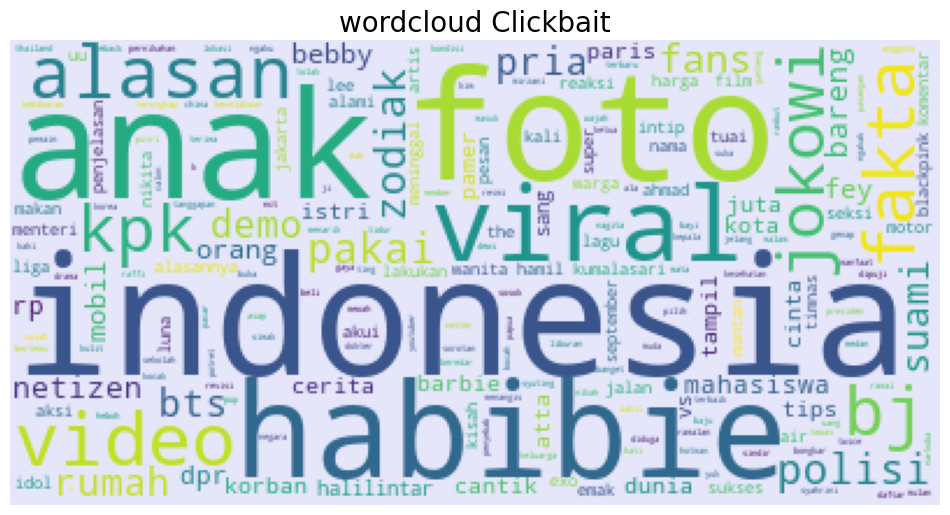

In [10]:
cb = word_word_word(cb_text['text'], 'Clickbait')
cb.word_cloud()

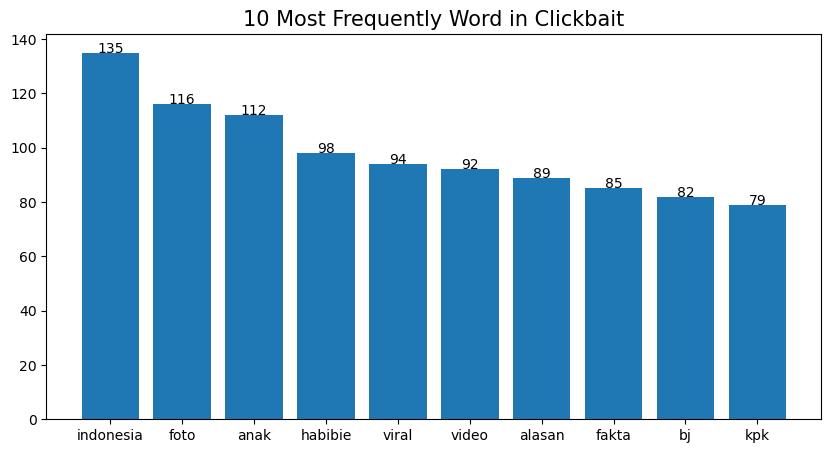

In [11]:
cb.most_common()

from the clickbait section, we can see that some of the words that appear most frequently are 'indonesia', 'foto','anak', 'habibie', 'viral', 'video', 'alasan', 'fakta', 'bj', 'kpk'

### non-clickbait

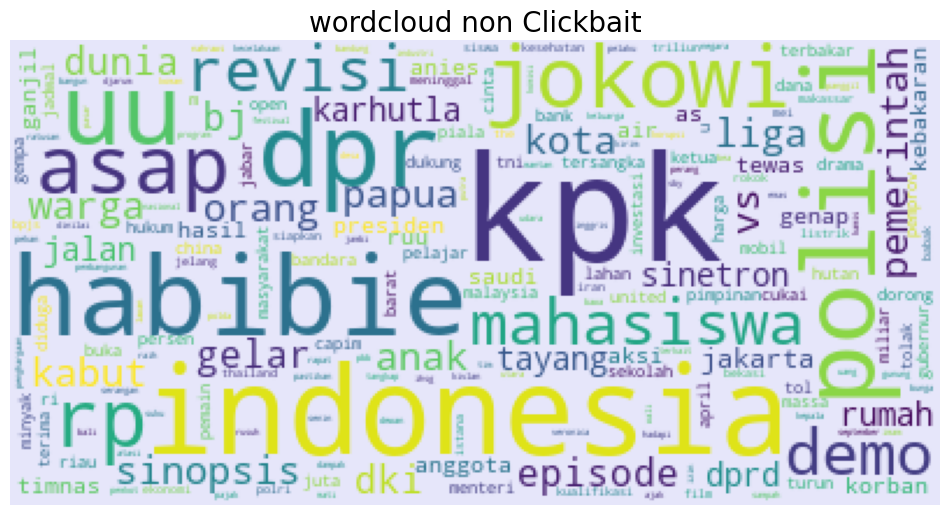

In [12]:
ncb = word_word_word(ncb_text['text'], 'non Clickbait')
ncb.word_cloud()

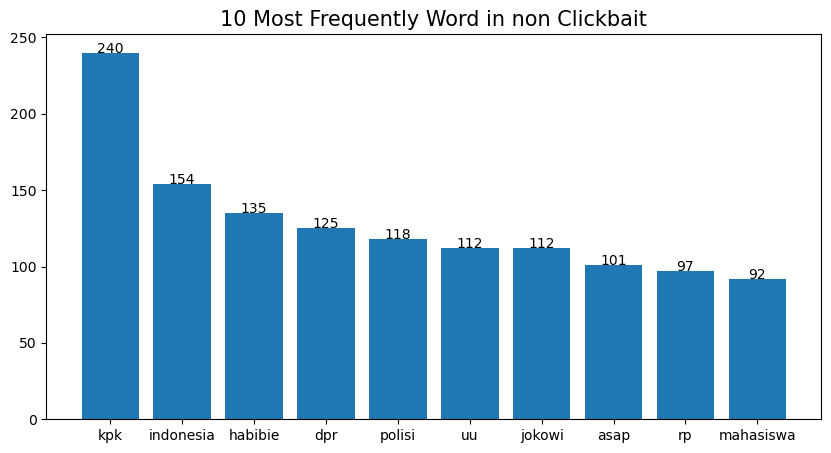

In [13]:
ncb.most_common()

from the non-clickbait section, we can see that some of the words that appear most frequently are 'kpk', 'indonesia', 'habibie', 'dpr', 'polisi', 'uu', 'jokowi', 'asap', 'rp', 'mahasiswa'

# **preprocessing part 2**

In [14]:
# Get length column for each text
data_balance['text_length'] = data_balance['text'].apply(len)#Calculate average length by label types
labels = data_balance.groupby('y').mean()
labels

,text_length
y,
0,49.997889
1,52.297648


In [15]:

X = data_balance['text']
y = data_balance['y']


In [16]:
#split to train and test data
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                   random_state=11)

source code: https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8

In [17]:
# Defining pre-processing hyperparameters
max_len = 55
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [18]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'kpk': 2,
 'indonesia': 3,
 'habibie': 4,
 'jokowi': 5,
 'polisi': 6,
 'anak': 7,
 'dpr': 8,
 'demo': 9,
 'uu': 10,
 'mahasiswa': 11,
 'bj': 12,
 'rp': 13,
 'asap': 14,
 'foto': 15,
 'revisi': 16,
 'papua': 17,
 'kota': 18,
 'orang': 19,
 'vs': 20,
 'warga': 21,
 'rumah': 22,
 'dunia': 23,
 'liga': 24,
 'sinopsis': 25,
 'kabut': 26,
 'alasan': 27,
 'video': 28,
 'mobil': 29,
 'viral': 30,
 'pemerintah': 31,
 'fakta': 32,
 'gelar': 33,
 'dki': 34,
 'episode': 35,
 'juta': 36,
 'air': 37,
 'jalan': 38,
 'korban': 39,
 'jakarta': 40,
 'cinta': 41,
 'presiden': 42,
 'pakai': 43,
 'fans': 44,
 'menteri': 45,
 'zodiak': 46,
 'aksi': 47,
 'timnas': 48,
 'pria': 49,
 'bareng': 50,
 'istri': 51,
 'suami': 52,
 'dprd': 53,
 'anggota': 54,
 'tewas': 55,
 'tayang': 56,
 'film': 57,
 'kebakaran': 58,
 'bts': 59,
 'karhutla': 60,
 'jelang': 61,
 'netizen': 62,
 'tolak': 63,
 'ruu': 64,
 'september': 65,
 'drama': 66,
 'turun': 67,
 'sinetron': 68,
 'meninggal': 69,
 'harga': 70,
 'ceri

every words have a specific index or codes, so the sentence could be convert into word index. <br> 
example: <br>
before: viral driver ojol bekasi pesanan makanan pakai sepeda <br>
after : ----1-----2-----3-------4---------5-----------6---------7-------8--- <br>
*ignore the dash (-)

In [19]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [20]:
print(x_train[0])
print(training_padded[0])

viral driver ojol bekasi pesanan makanan pakai sepeda
[  1   1  28   1  86   1  37   1 294   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


In [21]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

# Before padding
print(len(training_sequences[0]), len(training_sequences[1]))
# After padding
print(len(training_padded[0]), len(training_padded[1]))

Shape of training tensor:  (4642, 55)
Shape of testing tensor:  (1990, 55)
9 10
55 55


the data padded used to fulfill the input in modelling. This is relate with the mean of text length. We knew that the mean of text length is 49.99 for label '0' and 52.29 for label '1'. So if there any text with length less than that mean, gonna fill or padded with '0' value just for fulfill the model's input shape.

# **modelling**

In [22]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [23]:
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])



In [24]:
from tensorflow import keras

# fitting a dense spam detector model
num_epochs = 40
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(training_padded, 
                    y_train, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop], 
                    verbose=2)

Epoch 1/40
146/146 - 0s - loss: 0.6924 - accuracy: 0.5168 - val_loss: 0.6907 - val_accuracy: 0.5116
Epoch 2/40
146/146 - 0s - loss: 0.6876 - accuracy: 0.5900 - val_loss: 0.6814 - val_accuracy: 0.6719
Epoch 3/40
146/146 - 0s - loss: 0.6705 - accuracy: 0.6486 - val_loss: 0.6530 - val_accuracy: 0.6849
Epoch 4/40
146/146 - 0s - loss: 0.6322 - accuracy: 0.6853 - val_loss: 0.6070 - val_accuracy: 0.7090
Epoch 5/40
146/146 - 0s - loss: 0.5818 - accuracy: 0.7215 - val_loss: 0.5619 - val_accuracy: 0.7352
Epoch 6/40
146/146 - 0s - loss: 0.5346 - accuracy: 0.7417 - val_loss: 0.5293 - val_accuracy: 0.7437
Epoch 7/40
146/146 - 0s - loss: 0.4989 - accuracy: 0.7656 - val_loss: 0.5311 - val_accuracy: 0.7005
Epoch 8/40
146/146 - 0s - loss: 0.4830 - accuracy: 0.7686 - val_loss: 0.5018 - val_accuracy: 0.7467
Epoch 9/40
146/146 - 0s - loss: 0.4635 - accuracy: 0.7816 - val_loss: 0.4988 - val_accuracy: 0.7402
Epoch 10/40
146/146 - 0s - loss: 0.4601 - accuracy: 0.7770 - val_loss: 0.4964 - val_accuracy: 0.7392

In [25]:
# Model performance on test data 
model.evaluate(testing_padded, y_test)

63/63 [==============================] - 0s 503us/step - loss: 0.4996 - accuracy: 0.7442


[0.49957698583602905, 0.7442210912704468]

**early stopping**
<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-28_at_12.59.56_PM_1D7lrVF.png" width="300"><br>

Early Stopping is a regularization technique for deep neural networks that stops training when parameter updates no longer begin to yield improves on a validation set. In essence, we store and update the current best parameters during training, and when parameter updates no longer yield an improvement (after a set number of iterations) we stop training and use the last best parameters. It works as a regularizer by restricting the optimization procedure to a smaller volume of parameter space.<br>

source: <a href="https://paperswithcode.com/method/early-stopping">Early Stopping Explained</a> <br>

In [26]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    import matplotlib.pyplot as plt
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

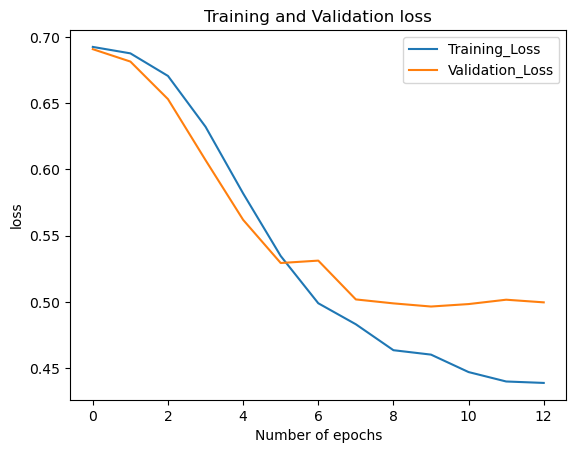

In [27]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

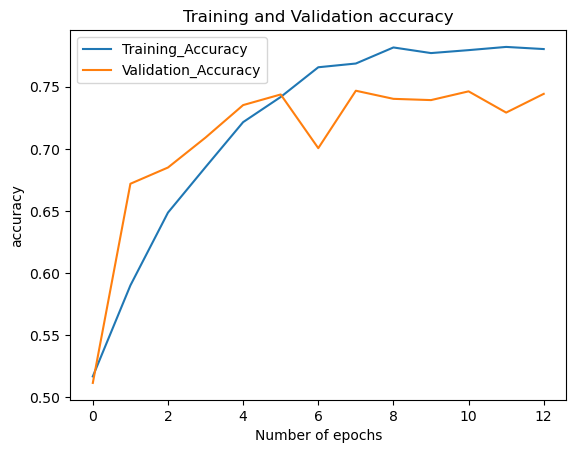

In [28]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [61]:
# model.save('my_model')

new_model = tf.keras.models.load_model('my_model')
new_model.predict(testing_padded)


array([[0.23970634],
       [0.9651457 ],
       [0.39351633],
       ...,
       [0.96344066],
       [0.39446947],
       [0.5074597 ]], dtype=float32)

## evaluate

In [ ]:
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

In [ ]:
#convert into list
list_y_test = list(y_test)
list_x_test = list(x_test)

#make the prediction and save it into list
hasil_pred = []
for i in list_x_test:
    hasil = predict_spam([i])[0][0]
    hasil_pred.append(round(hasil,0))

In [ ]:
#create confusion matrix
con_matrix = sklearn.metrics.confusion_matrix(list_y_test, hasil_pred)
con_matrix

In [ ]:
#visualization confusion matrix
cf_matrix = con_matrix

group_names = ['TF','FP','FN','TN']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, 
            annot=labels, 
            fmt='', 
            cmap='Blues').set(title='confusion matrix',xlabel='actual', ylabel='predicted')

In [ ]:
acc = (con_matrix[0][0] + con_matrix[-1][-1]) / np.sum(con_matrix)
print(acc)

## make prediction

In [ ]:
coba_text=['Viral Preman Palak Ibu Penjual Mie Pecal di Medan, Pelaku Ditangkap',
           'Terkuak Alasan Jaksa Sebut Bharada Eliezer Bukan Justice Collaborator',
           'Fakta-fakta Pembunuhan Berantai Wowon Cs di Bekasi-Cianjur',
           'Menakar Seberapa Berpengaruh Ridwan Kamil Bagi Golkar di 2024',
           'UU No. 6 Tahun 2014 soal Desa Penambahan Masa Jabatan Kepala Desa Hanya Melanggengkan Oligarki',
           'Menag Usulkan Biaya Haji Naik Jadi Rp69 Juta untuk Jemaah']


predict_spam(coba_text)

The score of prediction obtained from classification model that represent clickbait probability. If the score gets closer to 1, then the news headline more clickbait.